In [33]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numba import njit

In [34]:
def generate_data(function, point_count, x_min, x_max, std):
    x = np.linspace(x_min, x_max, point_count)
    y = function(x)
    y += np.random.random(point_count) * std - std / 2
    return x, y


In [35]:
x, y = generate_data(lambda x: 0.02*x**4 - 0.055*x**3 + 0.02*x - 0.01, 500, -3, 3, 0.1)

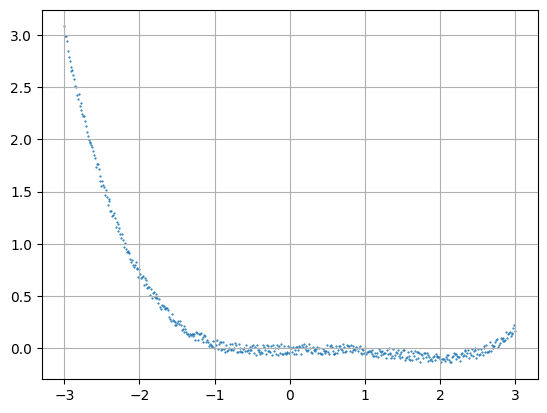

In [36]:
plt.scatter(x, y, s=0.3)
plt.grid()

In [37]:
@njit(parallel=True)
def fitness(individuals, points):
    fitnesses = []
    for ind in individuals:
        err = []
        for point in points:
            f_approx = 0
            for i in range(ind.shape[0]):
                f_approx += ind[i] * point[0] ** i
            err.append((f_approx - point[1]) ** 2)
        fitnesses.append(max(err))
    return np.array(fitnesses)


In [38]:
@njit(parallel=True)
def crossover(individuals, population_size):
    children = np.empty((population_size, individuals.shape[1]))
    for i in range(population_size):
        p1 = individuals[random.randint(0, individuals.shape[0] - 1), :]
        p2 = individuals[random.randint(0, individuals.shape[0] - 1), :]

        crossover_type = random.randint(0, 1)
        crosspoint = random.randint(1, individuals.shape[1])

        j1 = p1[:crosspoint]
        j2 = p2[crosspoint:]
        j3 = p2[:crosspoint]
        j4 = p1[crosspoint:]

        child = np.hstack((j1, j2)) if crossover_type else np.hstack((j3, j4))

        children[i, :] = child[:]
    return children


In [39]:
def mutation(individuals):
    mutation_count = random.randint(1, individuals.shape[1])
    for i in range(mutation_count):
        idx = random.randint(0, individuals.shape[0] - 1)
        bits_count = random.randint(1, individuals.shape[1])
        gen_max = max(individuals[idx])
        for j in range(bits_count):
            individuals[idx, random.randint(0, individuals.shape[1] - 1)] += np.random.uniform(-gen_max, gen_max)
    return individuals


In [40]:
def selection(individuals, fitnesses):
    to_sort = zip(individuals, fitnesses)
    sorted_zip = sorted(to_sort, key=lambda x: x[1])
    list1, list2 = map(list, zip(*sorted_zip))
    return np.array(list1), np.array(list2)

In [41]:
def genetic_algorithm(points, degree, population_size, err, max_iter, initial = float("inf")):
    population = np.random.random((population_size, int(degree) + 1))
    best_fitness = initial
    current_fitnesses = fitness(population, points)
    for _ in range(max_iter):
        population = crossover(population[:population_size // 2, :], population_size)
        population = mutation(population)
        current_fitnesses = fitness(population, points)
        population, current_fitnesses = selection(population, current_fitnesses)
        if current_fitnesses[0] < best_fitness:
            best_fitness = current_fitnesses[0]
            best_ind = population[0, :]
        if best_fitness < err:
            break
    return best_ind, best_fitness

In [46]:
points = np.hstack([x.reshape(x.shape[0], 1), y.reshape(y.shape[0], 1)], dtype=np.float64)
params, err = genetic_algorithm(points, 4, 100, 0.01, 10000)

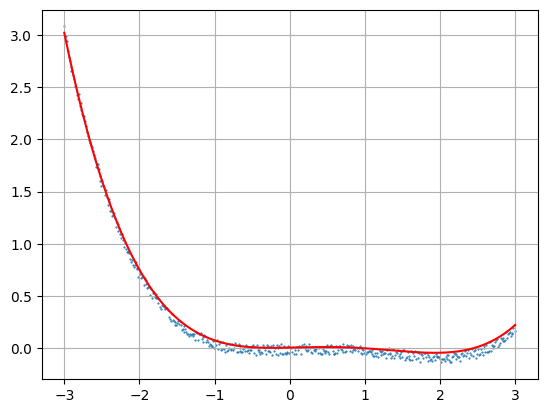

In [47]:
plt.scatter(x, y, s=0.3)
plt.plot(x, params[0] + params[1]*x + params[2]*x**2 + params[3]*x**3 + params[4]*x**4, c='r')
plt.grid()

In [48]:
err

0.009747899354461933

In [49]:
params

array([ 0.00651682,  0.01543576,  0.01308252, -0.0534912 ,  0.01847783])